In [9]:
from langgraph.types import Command
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../.env")

llm = init_chat_model(
    "ollama:deepseek-r1:70b", base_url=os.environ.get("OLLAMA_BASE_URL")
)


class State(TypedDict):
    document: str
    summary: str
    sentiment: str
    key_points: str
    recommendation: str
    final_analysis: str

In [10]:
def get_summary(state: State):
    response = llm.invoke(
        f"""
        Write a 3 sentence summary of this document {state["document"]}
        """
    )
    return {
        "summary": response.content,
    }


def get_sentiment(state: State):
    response = llm.invoke(
        f"""
        Analyse the sentiment and tone of this document {state["document"]}
        """
    )
    return {
        "sentiment": response.content,
    }


def get_key_points(state: State):
    response = llm.invoke(
        f"""
        List the 5 most important points of this document {state["document"]}
        """
    )
    return {
        "key_points": response.content,
    }


def get_recommendation(state: State):
    response = llm.invoke(
        f"""
        Based on the document, list 3 recommended next steps {state["document"]}
        """
    )
    return {
        "recommendation": response.content,
    }


def get_final_analysis(state: State):
    response = llm.invoke(
        f"""
        Give me an analysis of the following report

        DOCUMENT ANALYSIS REPORT
        ========================

        EXECUTIVE SUMMARY:
        {state['summary']}

        SENTIMENT ANALYSIS:
        {state['sentiment']}

        KEY POINTS:
        {state.get("key_points", "")}

        RECOMMENDATIONS:
        {state.get('recommendation', "N/A")}
        """
    )

    return {
        "final_analysis": response.content,
    }

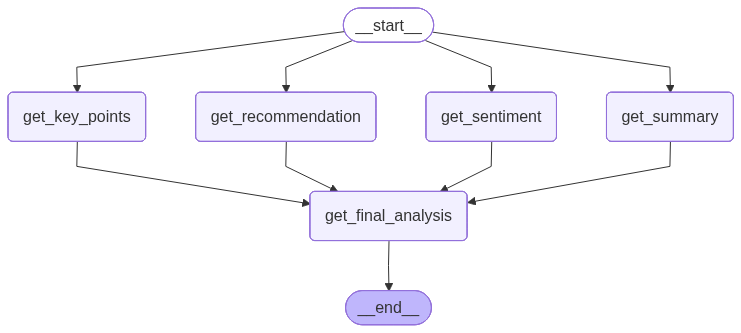

In [11]:
graph_builder = StateGraph(State)

graph_builder.add_node("get_summary", get_summary)
graph_builder.add_node("get_sentiment", get_sentiment)
graph_builder.add_node("get_key_points", get_key_points)
graph_builder.add_node("get_recommendation", get_recommendation)
graph_builder.add_node("get_final_analysis", get_final_analysis)

graph_builder.add_edge(START, "get_summary")
graph_builder.add_edge(START, "get_sentiment")
graph_builder.add_edge(START, "get_key_points")
graph_builder.add_edge(START, "get_recommendation")
graph_builder.add_edge("get_summary", "get_final_analysis")
graph_builder.add_edge("get_sentiment", "get_final_analysis")
graph_builder.add_edge("get_key_points", "get_final_analysis")
graph_builder.add_edge("get_recommendation", "get_final_analysis")
graph_builder.add_edge("get_final_analysis", END)


graph = graph_builder.compile()

graph

In [12]:
with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()

for chunk in graph.stream(
    {
        "document": document,
    },
    stream_mode="updates",
):
    print(chunk, "\n")

{'get_sentiment': {'sentiment': 'The press conference with Chair Powell highlights several key economic concerns and strategies:\n\n1. **Inflation and Employment Balance**: The Fed is focused on balancing low unemployment (4.3%) with controlled inflation. While inflation expectations remain stable, short-term increases are noted, potentially influencing consumer behavior.\n\n2. **Labor Market Challenges**: Job growth has slowed significantly, with both labor supply and demand decreasing. This slowdown could indicate broader economic weakness despite low unemployment rates.\n\n3. **Housing Market Struggles**: High interest rates are affecting housing affordability, exacerbated by a national shortage, especially in urban areas. Even with potential rate cuts, supply constraints may persist.\n\n4. **Interest Rate Policy**: The Fed is cutting rates to support the economy while normalizing the balance sheet post-pandemic. The runoff from this process is not seen as significantly impacting th